## Ferrari Dataset Preparation

In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

metadata_path = 'data/ferrari_dataset/ferrari_metadata.csv'
df = pd.read_csv(metadata_path)

df['label'] = df['model'].astype('category').cat.codes # Convert model names to categorical codes
label_mapping = dict(enumerate(df['model'].astype('category').cat.categories)) # Create a mapping from label codes to model names

In [2]:
label_mapping

{0: '12Cilindri',
 1: '296',
 2: '355',
 3: '512',
 4: '812',
 5: 'Concepts',
 6: 'Custom',
 7: 'Endurance Racing',
 8: 'F80',
 9: 'Formula 1',
 10: 'Novitec',
 11: 'Roma',
 12: 'SF90'}

In [3]:
df[['model', 'label']]

,model,label
0,12Cilindri,0
1,12Cilindri,0
2,12Cilindri,0
3,12Cilindri,0
4,12Cilindri,0
...,...,...
192,SF90,12
193,SF90,12
194,SF90,12
195,SF90,12


In [4]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset

class FerrariDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the image path and label for the given index
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]['image_path'])
        label = self.df.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
from sklearn.model_selection import train_test_split

def load_data(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    # Split the dataset into training and validation sets
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    
    # Create datasets for training and validation
    train_dataset = FerrariDataset(train_df, root_dir='data', transform=transform)
    test_dataset = FerrariDataset(test_df, root_dir='data', transform=transform)

    # Create data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [6]:
train_loader, test_loader = load_data()

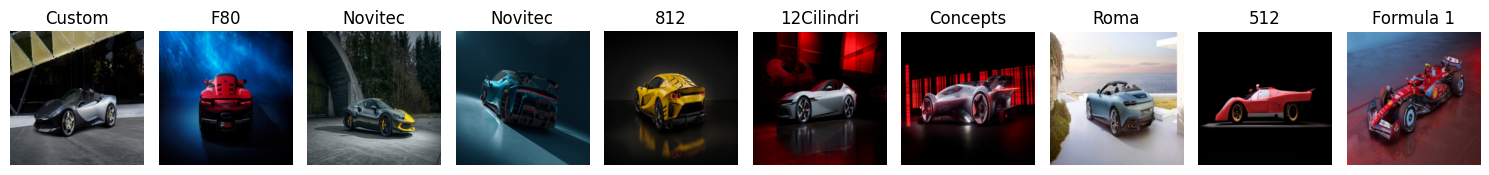

In [8]:
import matplotlib.pyplot as plt

def visualize_data(data_loader, num_samples=10, id2label=None):
    images, labels = next(iter(data_loader))

    # Sadece num_samples kadar alalım
    images = images[:num_samples]
    labels = labels[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0)  # (C, H, W) → (H, W, C)
        label = labels[i].item()
        axes[i].imshow(img)
        if id2label:
            axes[i].set_title(id2label[label])
        else:
            axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_data(train_loader, id2label=label_mapping)

In [9]:
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}, Image shape: {images.shape}, Labels shape: {labels.shape}")
    break  # Just to check the first batch

Batch size: 64, Image shape: torch.Size([64, 3, 224, 224]), Labels shape: torch.Size([64])


## CNN:
<img src="images/cnn.jpg"  width="900" height="450">

**Not:** Feature Learning = Feature Engineering = Feature Extraction

Her bir convolution layer her bir resim için feature mapping'ler oluşturur. Bu feature mapping'ler, ilgili resmin düşey, yatay, eğik kenarlarını, doku yapısını, renk geçişlerini ve şekil kalıpları gibi önemli bilgileri içerir.

**Conv1 =** Kenarlar, renk geçişleri

**Conv2 =** Basit şekiller, parça konturları

**Conv3+ =** Nesnenin yapısı, parçaları

Resmin boyutu ne kadar büyükse, daha fazla Conv+Pooling layer ihtiyacı olur:

|Görüntü Boyutu|Conv Sayısı|
|-----|------|
|32x32|2-3 Conv Layer|
|224x224|4-6 Conv Layer|
|512x512|6+ Conv Layer|

**Not:** Classification problemlerinde, +10 class için 4 conv layer ideal bir başlangıçtır. Duruma ve çıktılara göre sayısı arttırılabilir veya düşürülebilir.

Pooling Layer'lar, conv layer'lardan gelen çıktıları daha küçük boyutlara scale ederler. Bu scaling işlemindeki amaç, feature mapping'lerin fazlalık kısımlarının atılmasıdır. Böylece sonraki conv layer daha hızlı işlem yapabilir. Bu işlem bazı durumlarda bilgi kayıplarına yol açabilir.

Conv+pool layer'ların son kısmında elde edilen son çıktıyı 1D vector olacak şekilde boyutunu değiştiriyoruz. **(Flatten Layer ile)**
1D vector'ü fc layer'lara verilir. Bu sayede işlenmiş bilginin öğrenilmesi sağlanır.

```python
class Conv2d(
    in_channels: int, # RGB:3, Gray-scale:1
    out_channels: int, # Number of Filter or Number of Feature Map
    kernel_size: _size_2_t, # Filter Size (dim)
    stride: _size_2_t = 1, # What step to take when moving the filter each step
    padding: _size_2_t | str = 0, # Save image size adding zeros to the border. Thus, preventing data loss.
    dilation: _size_2_t = 1, # How much to extend the filter
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = "zeros",
    device: Any | None = None,
    dtype: Any | None = None
)
```

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Input: 3‑channel (RGB) images of size 224 × 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # 224x224 input, 16 filters of size 3x3 with pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # 112x112 input, 32 filters of size 3x3 with pooling
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 56x56 input, 64 filters of size 3x3 with pooling
        self.dropout = nn.Dropout(0.2)  # Dropout layer to prevent overfitting (%20 dropout rate)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 pooling layer
        
        # After three pooling layers the spatial size shrinks:
        # 224 → 112 → 56 → 28.  
        # The last conv layer outputs 64 channels, so the flattened vector is 64 × 28 × 28.
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes) # Output layer: one logit per class

    def forward(self, x):
        """
            Input shape: (3, 224, 224) 
                -> conv1 (16, 224, 224) -> relu -> pool (16, 112, 112)
                -> conv2 (32, 112, 112) -> relu -> pool (32, 56, 56) 
                -> conv3 (64, 56, 56) -> relu -> pool (64, 28, 28)
                -> flatten -> fc1 (512) -> relu -> dropout -> fc2 (num_classes)
            Output shape: (num_classes)
        """
        # Forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 64 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x) # Apply dropout to the fully connected layer
        
        x = self.fc2(x) # No activation here; CrossEntropyLoss applies softmax internally
        return x

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
num_classes = len(label_mapping)
model = SimpleCNN(num_classes=num_classes).to(device)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001

In [18]:
# Training the Model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    """Train the model on the training dataset."""
    model.train() # Set the model to training mode
    
    running_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.long().to(device) # Move data to device
            
            optimizer.zero_grad() # Zero the gradients (Because we don't want to use previous gradients)
            
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backward pass (Calculate gradients)
            optimizer.step() # Update weights
            
            total_loss += loss.item() # Accumulate loss
        
        avg_loss = total_loss / len(train_loader) # Average loss for the epoch
        running_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Plot the training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), running_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

Epoch [1/50], Loss: 0.4957
Epoch [2/50], Loss: 0.3734
Epoch [3/50], Loss: 0.3704
Epoch [4/50], Loss: 0.3045
Epoch [5/50], Loss: 0.3205
Epoch [6/50], Loss: 0.2651
Epoch [7/50], Loss: 0.1878
Epoch [8/50], Loss: 0.2085
Epoch [9/50], Loss: 0.1830
Epoch [10/50], Loss: 0.1882
Epoch [11/50], Loss: 0.1505
Epoch [12/50], Loss: 0.1819
Epoch [13/50], Loss: 0.1562
Epoch [14/50], Loss: 0.1537
Epoch [15/50], Loss: 0.1809
Epoch [16/50], Loss: 0.1323
Epoch [17/50], Loss: 0.1415
Epoch [18/50], Loss: 0.1527
Epoch [19/50], Loss: 0.1446
Epoch [20/50], Loss: 0.1240
Epoch [21/50], Loss: 0.1392
Epoch [22/50], Loss: 0.1471
Epoch [23/50], Loss: 0.1528
Epoch [24/50], Loss: 0.1453
Epoch [25/50], Loss: 0.1422
Epoch [26/50], Loss: 0.1339
Epoch [27/50], Loss: 0.1477
Epoch [28/50], Loss: 0.1339
Epoch [29/50], Loss: 0.1111
Epoch [30/50], Loss: 0.1280
Epoch [31/50], Loss: 0.1278
Epoch [32/50], Loss: 0.1458
Epoch [33/50], Loss: 0.1736
Epoch [34/50], Loss: 0.1073
Epoch [35/50], Loss: 0.1492
Epoch [36/50], Loss: 0.1315
E

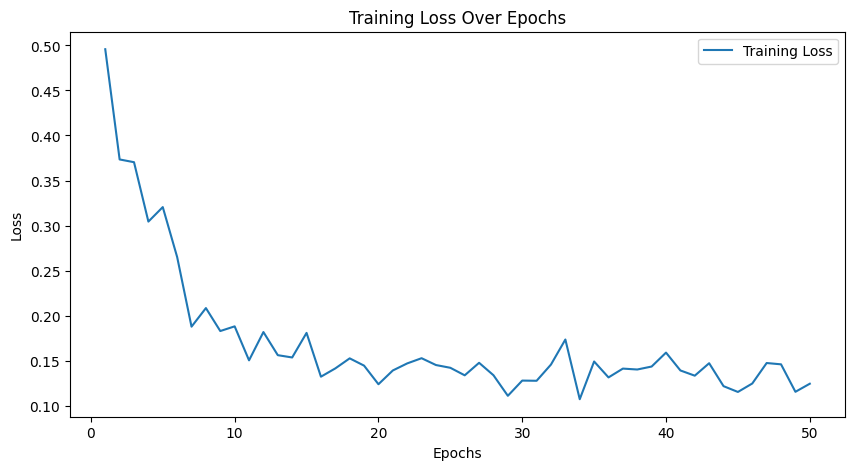

In [22]:
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

In [25]:
# Testing the Model and Evaluating Performance
def test_model(model, test_loader, test_type='test'):
    """Test the model on the test dataset and evaluate its performance."""
    model.eval() # Set the model to evaluation mode
    correct = 0 # Number of correct predictions
    total = 0 # Total number of samples
    
    with torch.no_grad(): # No need to calculate gradients during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # Move data to device
            
            predictions = model(images) # Forward pass
            
            _, predicted_idx = torch.max(predictions, 1) # Get the highest predicted class index
            total += labels.size(0) # Update total samples
            correct += (predicted_idx == labels).sum().item() # Count correct predictions
    
    accuracy = 100 * correct / total # Calculate accuracy
    print(f'{test_type} Accuracy: {accuracy:.3f}%')

In [27]:
test_model(model, train_loader, test_type='Train') # Test the model on the train dataset

Train Accuracy: 91.720%


In [ ]:
test_model(model, test_loader, test_type='Test') # Test the model on the test dataset

Test Accuracy: 35.000%


In [29]:
torch.cuda.empty_cache() # Clear the GPU memory cache